In [64]:
os.getcwd()

'C:\\Users\\KRG\\Desktop\\github_repo_placement\\placement_analysis\\one_for_all_func'

In [47]:
os.chdir('..')
os.chdir('..')
# os.chdir('one_for_all_func')

In [ ]:
from docx import Document
import pandas as pd

# os.chdir('..')
# os.chdir('..')
# os.chdir('placement_analysis/one_for_all_func')
mapping_data = pd.read_excel('placement_analysis/one_for_all_func/mapping_new10.xlsx')

In [72]:
# %%time
# %load_ext memory_profiler

import pandas as pd
import os
from docx import Document
from bertopic import BERTopic
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim

def ls(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def pp(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 1:
            result.append(ls(token))
    result = ' '.join(result)
    return result

def get_ques_list(folder):
    os.chdir(folder)
    os.chdir('company')
    list_of_files = os.listdir()
    all_ques = {}
    for filename in list_of_files:
        if filename.endswith('.docx'):
            doc = Document(filename)
            fullText = []
            for para in doc.paragraphs:
                fullText.append(para.text)
            doctxt = fullText
            fullText = []
            for eachl in doctxt:
                if len(eachl) == 0:
                    continue
                elif eachl[0] == 'Q':
                    fullText.append(eachl.split(" ", 1)[1])
                else:
                    fullText[len(fullText)-1] = fullText[len(fullText)-1] + ' ' + eachl

            all_ques[filename[:len(filename)-5]] = fullText
    return all_ques

def get_topics_with_mapping(docx_path, model_path='model', num_topics=2, csv_path='mapping.csv'):
    # Get questions list
    ques_list_per_company = get_ques_list(docx_path)
    
    os.chdir('..')
    # Load mapping data from CSV file
    mapping_data = pd.read_csv(csv_path)

    model = BERTopic.load(model_path)

   # Process each question and get topics
    all_topics_per_company = {}
    for key, value in ques_list_per_company.items():
        ques_list = value
        one_company_topics = []
        for idx, ques in enumerate(ques_list):
            preprocessed_question = pp(ques)
            similar_topics, _ = model.find_topics(preprocessed_question, top_n=num_topics)

            # Map bucket_topic_number to book_topic_number with highest non-zero score
            book_topic_number_1, book_topic_number_2 = None, None
            score_1, score_2 = 0.0, 0.0
            for topic_number in similar_topics:
                # Filter the mapping data for the current bucket_topic_number
                topic_data = mapping_data[mapping_data['bucket_topic_number'] == topic_number + 1]
                
                # Get the book_topic_number and corresponding score
                if not topic_data.empty:
                    current_score = topic_data['score'].max()
                    current_book_topic_number = topic_data.loc[topic_data['score'].idxmax()]['book_topic_number']

                    # Assign to variables based on score
                    if current_score >= score_1:
                        score_2, score_1 = score_1, current_score
                        book_topic_number_2, book_topic_number_1 = book_topic_number_1, current_book_topic_number
                    elif current_score >= score_2:
                        score_2 = current_score
                        book_topic_number_2 = current_book_topic_number

            # Get the names of topics
            book_topic_1 = mapping_data[mapping_data['book_topic_number'] == book_topic_number_1]['book_topic'].values[0] if book_topic_number_1 is not None else None
            book_topic_2 = mapping_data[mapping_data['book_topic_number'] == book_topic_number_2]['book_topic'].values[0] if book_topic_number_2 is not None else None

            # Store the topics for the company
            one_company_topics.append((ques, similar_topics, (book_topic_number_1, score_1, book_topic_1), (book_topic_number_2, score_2, book_topic_2)))

        all_topics_per_company[key] = one_company_topics

    os.chdir('..')
    return all_topics_per_company

# Example usage
subject_fold = input()
result = get_topics_with_mapping(subject_fold)

# Print the results
for company, question_topics_list in result.items():
    print(f"For Company {company}:")
    for idx, (question, topics, (book_topic_number_1, score_1, book_topic_1), (book_topic_number_2, score_2, book_topic_2)) in enumerate(question_topics_list, start=1):
        print(f"  Question {idx}: {question}")
        print(f"    Topics: {topics}")
        print(f"    Book Topic 1: {book_topic_number_1} - {book_topic_1} (Score: {score_1})")
        print(f"    Book Topic 2: {book_topic_number_2} - {book_topic_2} (Score: {score_2})")
        
# %memit question_topics_list
# %memit list_of_topics_per_company

Networking
For Company Amazon:
  Question 1: What do you mean by network topology?
    Topics: [70, 420]
    Book Topic 1: 19 - Software-Defined Networking (SDN) (Score: 0.293820391)
    Book Topic 2: 0 - Introduction to Computer Networks (Score: 0.0)
  Question 2: What are the advantages of Distributed Processing?
    Topics: [294, 279]
    Book Topic 1: 4 - Network Layers and the OSI Model (Score: 0.139913189)
    Book Topic 2: 0 - Introduction to Computer Networks (Score: 0.0)
  Question 3: What is the criteria to check the network reliability?
    Topics: [345, 70]
    Book Topic 1: 23 - Network Performance Optimization (Score: 0.736313927)
    Book Topic 2: 19 - Software-Defined Networking (SDN) (Score: 0.293820391)
  Question 4: What are the different factors that affect the performance of a network?
    Topics: [345, 126]
    Book Topic 1: 23 - Network Performance Optimization (Score: 0.736313927)
    Book Topic 2: 23 - Network Performance Optimization (Score: 0.73222505)
  Ques

In [73]:
def calculate_company_book_topic_frequencies(result):
    # Initialize a dictionary to store the frequencies of book topics for each company
    company_book_topic_frequencies = {}

    # Iterate over the result data to count the frequencies for each company
    for company_name, company_data in result.items():
        # Initialize a dictionary for the current company
        book_topic_frequencies = {}

        # Count the frequencies for each book topic
        for _, _, (book_topic_number_1, _, book_topic_1), (book_topic_number_2, _, book_topic_2) in company_data:
            # Count the frequency of book_topic_1
            book_topic_frequencies[book_topic_1] = book_topic_frequencies.get(book_topic_1, 0) + 1
            # Count the frequency of book_topic_2
            book_topic_frequencies[book_topic_2] = book_topic_frequencies.get(book_topic_2, 0) + 1

        # Store the book topic frequencies for the current company
        company_book_topic_frequencies[company_name] = book_topic_frequencies

    # Return the resulting dictionary
    return company_book_topic_frequencies

# Example usage:
# result = ...  # Your result dictionary
company_book_topic_frequencies = calculate_company_book_topic_frequencies(result)

# Print the resulting dictionary
print("Company Book Topic Frequencies:")
for company, book_topic_freqs in company_book_topic_frequencies.items():
    print(f"For Company {company}:")
    for book_topic, frequency in book_topic_freqs.items():
        print(f"  {book_topic}: {frequency}")


Company Book Topic Frequencies:
For Company Amazon:
  Software-Defined Networking (SDN): 11
  Introduction to Computer Networks: 16
  Network Layers and the OSI Model: 9
  Network Performance Optimization: 5
  Network Devices and Hardware: 1
  TCP/IP Protocol Suite: 20
  Wireless Security: 6
  Network Virtualization: 2
  VLANs (Virtual LANs): 5
  Network Design and Planning: 5
  Ethernet and LAN Technologies: 3
  Network Routing and Switching: 6
  Internet of Things (IoT) and Networking: 1
  Wireless Networking: 5
  DNS (Domain Name System): 1
  VPN (Virtual Private Network): 2
  Network Topologies and Architectures: 1
  Network Models and Protocols: 3
For Company Google:
  Network Layers and the OSI Model: 6
  Internet of Things (IoT) and Networking: 1
  Wireless Networking: 5
  Wireless Security: 9
  VLANs (Virtual LANs): 7
  Quality of Service (QoS): 6
  Network Performance Optimization: 3
  Network Devices and Hardware: 2
  Software-Defined Networking (SDN): 11
  Network Design and

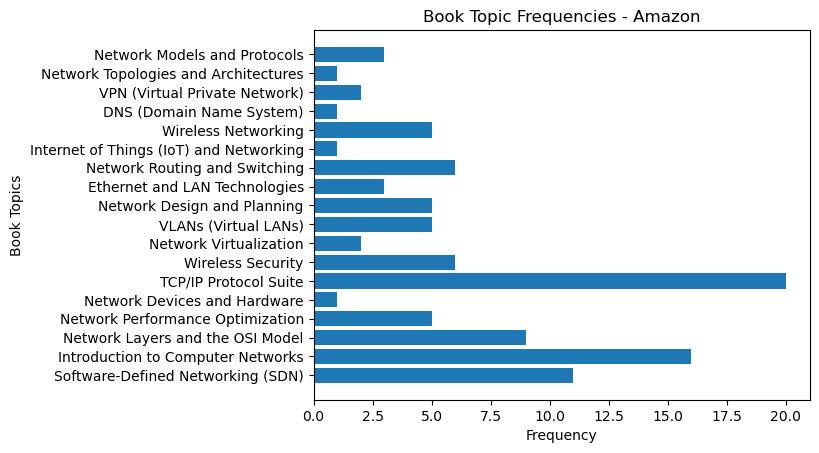

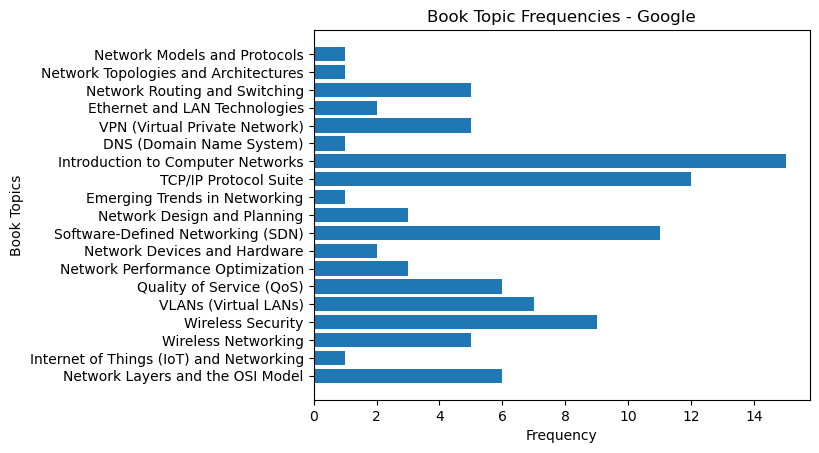

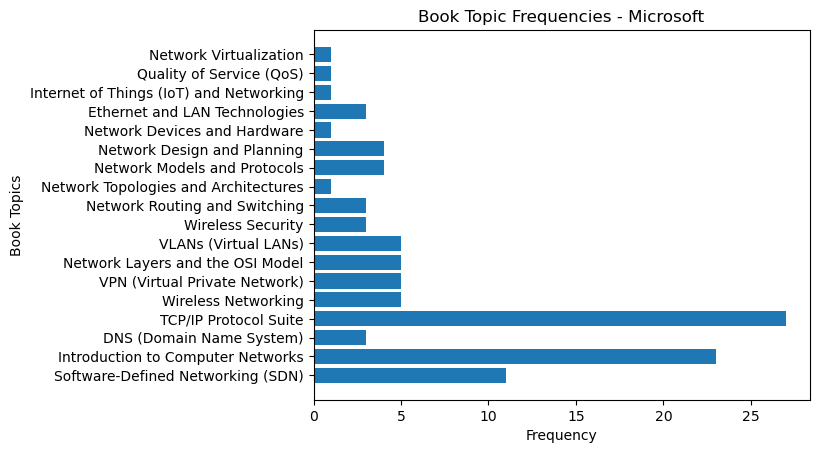

In [77]:
# Function to plot and save horizontal bar graphs for each company
def plot_and_save_book_topic_frequencies(company_book_topic_frequencies,docx_path):
    os.chdir(docx_path)
    os.chdir('graph')
    for company, book_topic_frequencies in company_book_topic_frequencies.items():
        # Extracting book topics and corresponding frequencies for the current company
        book_topics = list(book_topic_frequencies.keys())
        frequencies = list(book_topic_frequencies.values())

        # Plotting the horizontal bar graph for the current company
        plt.barh(book_topics, frequencies)
        plt.title(f'Book Topic Frequencies - {company}')
        plt.ylabel('Book Topics')
        plt.xlabel('Frequency')
        plt.savefig(f'book_topic_frequencies_{company}.png', bbox_inches='tight')  # Save image for each company
        plt.show()
        
    os.chdir('..')
    os.chdir('..')
    
    
plot_and_save_book_topic_frequencies(company_book_topic_frequencies,subject_fold)